# Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import matplotlib.pyplot as plt

In [2]:
login_df = pd.read_json('logins.json')
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
# Make copy of original data
df = pd.DataFrame.copy(login_df)

# Set index to be the timestamps, to allow aggregation
df.set_index('login_time', inplace=True) 

# Each timestamp has 1 count
df['count'] = 1 

# Aggregate by 15-min intervals
df_15 = df.resample('15T').sum() 

In [5]:
# 15 Min Interval Login DF Overview
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


/Users/shrsudha/anaconda3/envs/capstone/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


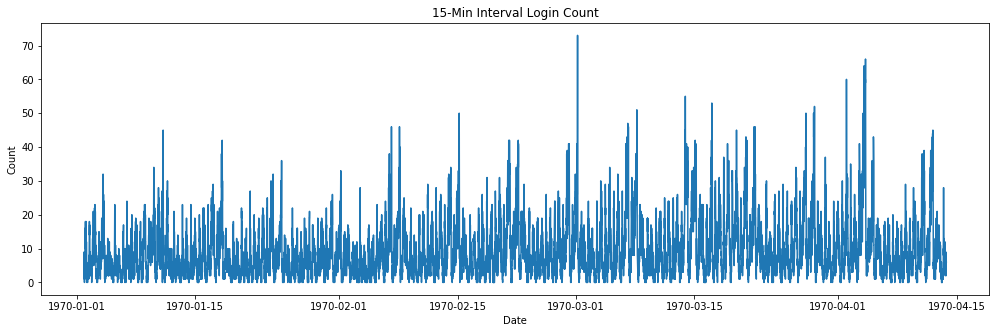

In [6]:
# 15 Min Interval Login Plot 
plt.figure(figsize=(17,5));
plt.plot(df_15);
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('15-Min Interval Login Count');

The plot is difficult to interpret beyond just large chunks of dates. 

We could see spike in logins near the beginning of March as something of significance.

But, let's narrow the figure down to different time-levels.

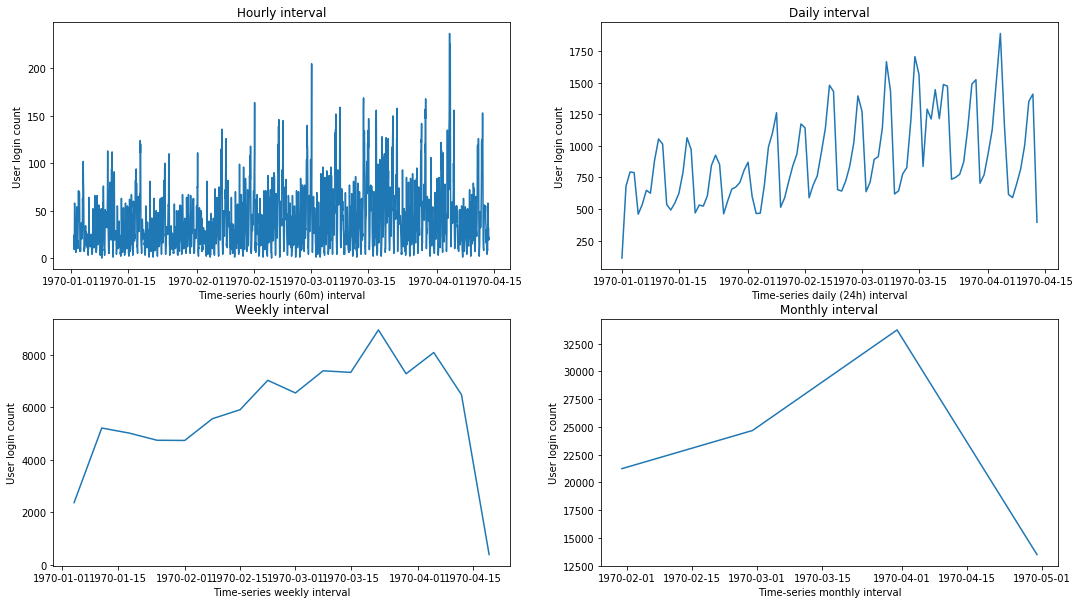

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(df.resample('60T').sum());
ax1.set(xlabel='Time-series hourly (60m) interval', ylabel='User login count', title='Hourly interval');

# Daily interval
ax2.plot(df.resample('D').sum());
ax2.set(xlabel='Time-series daily (24h) interval', ylabel='User login count', title='Daily interval');

# Weekly interval
ax3.plot(df.resample('W').sum());
ax3.set(xlabel='Time-series weekly interval', ylabel='User login count', title='Weekly interval');

# Monthly interval
ax4.plot(df.resample('M').sum());
ax4.set(xlabel='Time-series monthly interval', ylabel='User login count', title='Monthly interval');

We see a general cyclic pattern emerging from the "Daily interval" figure.

It seems there might be certain hours of the day at which there are more user logins than other parts of day.

In [8]:
# Grab logins on Feb 4, 1970
mask = (login_df['login_time'] > datetime.date(1970, 2, 3)) & (login_df['login_time'] <= datetime.date(1970, 2, 4))
df_day = login_df[mask]

/Users/shrsudha/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [9]:
# Aggregate into 60-min intervals
df = pd.DataFrame.copy(df_day) 
df.set_index('login_time', inplace=True) 
df['count'] = 1 
df_60 = df.resample('60T').sum()

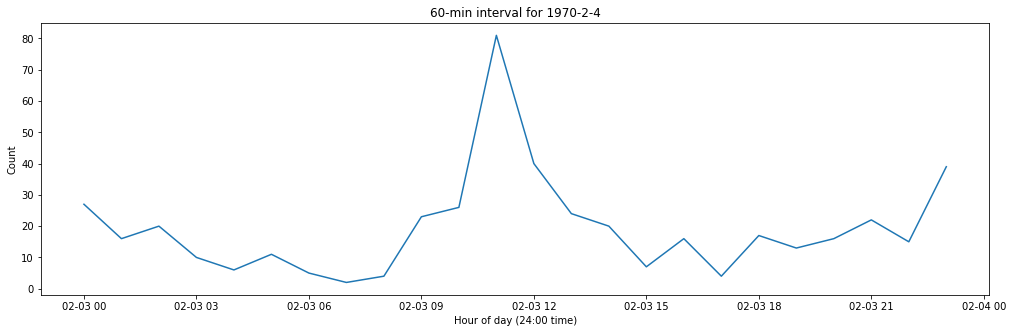

In [10]:
# Plot
plt.figure(figsize=(17,5));
plt.plot(df_60);
plt.xlabel('Hour of day (24:00 time)');
plt.ylabel('Count');
plt.title('60-min interval for 1970-2-4');

For this particular date:

Morning and evening have lowest user logins.

Logins pick up around 9 AM (possible: rush hour to work) and peak right before noon (possible: rush hour to lunch).

Then they drop off, although they may pick up slightly before midnight (possible: returning from "going out" hours).

https://github.com/diana-xie/ultimate_challenge/blob/master/ultimate_challenge.ipynb

# Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

##### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Determine the change in pre- and post-reimbursement number of times driver has crossed the bridge, since this will indicate whether there is an increase, decrease, or no change in how often driver partners served both cities after the experiment.

A significant post-reimbursement increase in driver crossings supports the experiment's success - driver partners tended to serve both cities more often after the experiment's introduction.

##### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

Implementing experiment

Conduct a one-sided, 1-sample z-test, assuming sample size > 30 drivers. Compare number driver bridge crossings (where a crossing = crossing the bridge + serving crossed-to city) pre- and post-reimbursement.

$h_0$: No difference in driver bridge crossings, after toll reimbursement experiment.
$h_a$: Increase in driver bridge crossings, after toll reimbursement experiment.
Null hypothesis distribution is simply the distribution of driver crossings before toll reimbursement experiment.

Calculate z-score of average frequency of drivers serving both cities, post-reimbursement experiment.
Set $a$=0.05. Determine if z-score's p-value falls below this significance threshold.
Interpreting results
If p-value < 0.05, then the post-reimbursement crossings are so high that it's unlikely to occur under the null hypothesis of pre-reimbursement crossings. This result would support a significant increase in driver bridge crossings after the toll reimbursement is introduced, indicating that this policy was a success.

Caveats & recommendations
However, the caveat is that $a$ significance levels are set arbitrarly and p-values fluctuate depending on sample size. So depending on how wide of a margin the post-reimbursement increase is, our experiment could either support or reject the policy.

As a result, I recommend only considering the policy a success if the margin is wide enough (and p-value far below 0.05) that it is obvious that a significant post-reimbursement increase has occurred even in the midst of the aforementioned fluctuations.

# Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

Use the data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. 

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [11]:
df_users = json.load(open('ultimate_data_challenge.json')) 
df_users = pd.DataFrame(df_users) 
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### What fraction of the observed users were retained?

In [12]:
from dateutil import parser
from datetime import timedelta

# Retrieve date when data was last pulled
df_users['last_trip_date'] = pd.to_datetime(df_users['last_trip_date']) 
date_pulled = max(df_users['last_trip_date']) 

# Find cutoff date 
cutoff_date = date_pulled - timedelta(days=30)
print("Cut-off date': ", cutoff_date)

# Compute user retained percentage
df_retained = df_users[df_users['last_trip_date'] >= cutoff_date]
print("Fraction of observed users retained: ", len(df_retained) / len(df_users))

Cut-off date':  2014-06-01 00:00:00
Fraction of observed users retained:  0.37608


### Build a predictive model

1. Get users still active in their 6th month in system

In [13]:
# Set up
df_users['signup_date'] = pd.to_datetime(df_users['signup_date'])
month_6 = df_users['signup_date'] + timedelta(days=153) 

# Get users active in their 6th month in system
active_idx = [idx for idx, s in enumerate(df_users['last_trip_date']) if s > month_6[idx]] 

# Append data to our database (useful for data viz later)
df_users['active'] = 0 # set default to 0
df_users.loc[active_idx, 'active'] = 1 # set active users to 1

print("Number of active users: ", len(active_idx))
print("Number of inactive users: ", len(df_users) - len(active_idx))
print("Percent active users: ", len(active_idx)/len(df_users))

Number of active users:  10599
Number of inactive users:  39401
Percent active users:  0.21198


2. Convert columns w/ string values to int

In [14]:
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [15]:
print("city: ", df_users['city'].unique())
print("phone: ", df_users['phone'].unique())
print("ultimate_black_user: ", df_users['ultimate_black_user'].unique())

city:  ["King's Landing" 'Astapor' 'Winterfell']
phone:  ['iPhone' 'Android' None]
ultimate_black_user:  [ True False]


In [16]:
# Convert cities
cities = {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
df_users['city'] = df_users['city'].map(lambda x: cities[x])

# Convert phones
phones = {"iPhone": 1, "Android": 2}
df_users['phone'] = df_users['phone'].map(lambda i: phones[i] if i is not None else 0)

# Convert ultimate black status
df_users['ultimate_black_user'] = df_users['ultimate_black_user'].map(lambda b: 1 if b == True else 0)

In [17]:
# Replace missing values
df_users['avg_rating_by_driver'].fillna(df_users['avg_rating_by_driver'].mean(), inplace=True)
df_users['avg_rating_of_driver'].fillna(df_users['avg_rating_of_driver'].mean(), inplace=True)

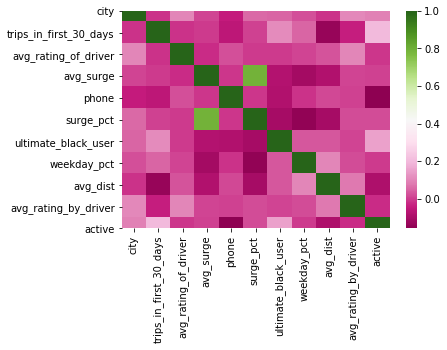

In [18]:
# Determine meaningful features: Corelations 
sns.heatmap(df_users.corr(), cmap="PiYG");

3.  Drop selected features

Let's drop 'surge_pct', 'avg_surge', and 'phone' as they don't contribute to final o/p.

Let's also drop 'last_trip_date' and 'signup_date', as they were used to determine whether the user was active earlier

In [19]:
df_users.drop(['surge_pct', 'avg_surge', 'phone', 'last_trip_date', 'signup_date'], inplace=True, axis=1)

In [20]:
df_users.head()

,city,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,3,4,4.7,1,46.2,3.67,5.0,0
1,2,0,5.0,0,50.0,8.26,5.0,0
2,2,3,4.3,0,100.0,0.77,5.0,0
3,3,9,4.6,1,80.0,2.36,4.9,1
4,1,14,4.4,0,82.4,3.13,4.9,0


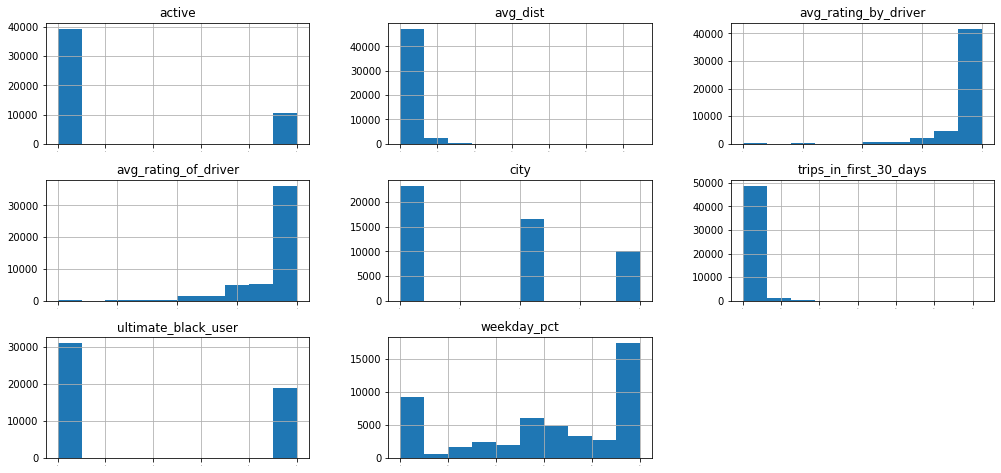

In [21]:
# Check distribution of features
df_users.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8));

In [22]:
from sklearn.preprocessing import MinMaxScaler

x = df_users.drop('active', axis=1)
y = df_users['active']

scaler = MinMaxScaler()
scaler.fit(x)

x = scaler.fit_transform(x)

4. Preapare Dataset

In [26]:
# Split the data into train & test sets before modeling

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = {'max_depth':range(2,7), 'min_samples_split':range(100,1000,200)}
model = RandomForestClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=5)
clf.fit(X_train, y_train)

In [ ]:
print("Best parameters set found on development set:")
print(clf.best_params_, '\n')

print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']

stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)

print(confusion_matrix(y_true, y_pred), '\n')

In [ ]:
# Recreate our best model
model = RandomForestClassifier(max_depth=6, min_samples_split=300, random_state=99)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(x_test)

In [ ]:
len(y_true == y_pred) / len(y_true)

In [ ]:
# Plot relative importance of features
plt.figure(figsize=(14,6));
plt.bar(df_users.columns[:-1].tolist(), model.feature_importances_);
plt.title('Relative importance of features');